In [1]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import math

In [2]:
class OutputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "wb")
        return self
       
    def write(self, value, length):
        assert isinstance(value, int), "value must be integer"
        assert isinstance(length, int), "length must be integer"
        assert value >= 0, "value must be non negative"
        assert value < 2 ** length, "value must be smaller than 2 ** length"
       
        self.word <<= length
        self.word |= value
        self.word_bits += length
   
        if self.word_bits >= 64:
            remaining = self.word_bits - 64
            self.file.write((self.word >> remaining).to_bytes(8, byteorder="big", signed=False))
            self.word &= (1 << remaining) - 1
            self.word_bits = remaining
   
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.word_bits != 0:
            self.write(0, 64 - self.word_bits)
           
        self.file.close()

In [3]:
class InputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "rb")
        return self
       
    def read(self, length):
        assert length < 8 * 32, "length is too large"
       
        if length > self.word_bits:
            value = self.file.read(32)
            self.word <<= len(value) * 8
            self.word_bits += len(value) * 8
            self.word |= int.from_bytes(value, byteorder="big", signed=False)
           
        if length > self.word_bits:
            raise "Unexpected end of file"
               
        result = self.word >> (self.word_bits - length)
        self.word_bits -= length
        self.word &= (1 << self.word_bits) - 1
       
        return result
   
    def __exit__(self, exc_type, exc_val, exc_tb):    
        self.file.close()

---------
12
[255 255 255 255 255 255 255 255 255 255 255 255 151   0  23 255  87 151
 255 255  23 215 255 255 255 255  87 151 255 255  23   0   0   0  23 255
  87 151 255 255  23 215 151   0  23 255 255 151  87 255 255 255 255 215
  23 255 255 151  87 255  23   0 151 255 255 255 255 151  87 255 255  87
 151 255 255  23   0   0   0  23 255  87 151 255 255 255 255 151  87 255
 255  87   0  87 255  23 215 255 215  23 255 255 151   0   0   0   0 151
 215  23 255 255 255 215   0   0   0   0  87 255  23 215 151  87 255  23
 215 255 215   0   0   0   0  87 255 255  87 151 255 255  23   0 151 255
 255 255  87 151 255 255  23 215 151   0   0   0   0 151 255 255  23 215
 255 215   0   0   0 151 255 255 255  87   0  87 255  23 215 151   0  23
 255 255 255 215   0   0   0 151 215  23 255  87   0  87 255 255 255 255
 255 255 255 255 255 255 255 255]
La fila es repeteix fins la fila 100


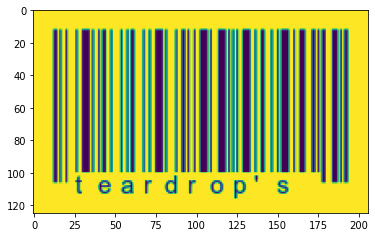

In [4]:
img = imageio.imread("barcodes/sample-000001.png")
plt.imshow(img) #im

primeraLinea = 0
segonaLinea = 0
ultimaRepetida = 0

for fila in range(img.shape[0]):
    for columna in range(img.shape[1]):
        if img[fila][columna] != 255:
            if primeraLinea == 0:
                primeraLinea = fila
                segonaLinea = fila+1


segonaLinea = img[segonaLinea]

for x in range(primeraLinea+1, img.shape[0]):
    
    if False in (img[x] == segonaLinea):
        if ultimaRepetida == 0:
            ultimaRepetida = x

print('---------')
print(primeraLinea)
print(segonaLinea)
print("La fila es repeteix fins la fila", ultimaRepetida)


In [5]:
for i in range(2,4):
    print(i)
    if i ==2:
        break;

2


In [6]:
img.shape[0]

125

In [32]:
#Fins ara tenim una funcio que retorna la ultima fila que es repeteix dins del barcode
# codeBook = primeraLinia + SegonaLinia + totes les linies que no es repeteixen
# a cada linia li podem dir codeword
# per ara hardcodegem les mesures, ja les enviarem

codeBook =[]
codeBook.append(img[primeraLinea])
codeBook.append(segonaLinea)

wordImage = []

for i in range(ultimaRepetida, img.shape[0]):
    for value in img[i]:   
        wordImage.append(value)
    codeBook.append(img[i])
#wordImageNP = np.array(wordImage)
#wordImageNP.resize(img.shape[1],img.shape[0]-ultimaRepetida)

print("Generat Codebook")


Generat Codebook


In [11]:
#Escribim el codeBook
with OutputBitstream("quantized.bin") as f:
    f.write(img.shape[0], 32)
    f.write(img.shape[1], 32)
    f.write(len(codeBook), 32)
    #write codebbook
    #tambe hauriem d'afegir els index de primeraLinea i ultimaRepetida
    for codeword in codeBook:
        for value in codeword:
            f.write(int(value), 8)
#surt un binari de 6KB quan la foto es de 1KB, mu mal


In [12]:
with InputBitstream("quantized.bin") as f:
    x = f.read(32)
    y = f.read(32)
    lenCodeBook = f.read(32)
    
    recoveredImage = np.empty((x,y), dtype="uint8")
    
    liniesBlanques = np.arange(y)
    liniesBlanques.fill(255)

    for indexLiniaBlanca in range(0,12): #12 pot ser primeraLinea
        recoveredImage[indexLiniaBlanca] = (liniesBlanques[indexLiniaBlanca])
        #recoveredImage.append(liniesBlanques[indexLiniaBlanca])
    #fins aqui omplim les primeres linies de blanc
    inedxMatriu=12
    #for codeWord in codeBook:
    valor=ultimaRepetida
    for index in range (0,lenCodeBook):
        codeWord= f.read(8)
        if i==0:
            recoveredImage[12] = codeWord
            #recoveredImage.append(codeWord)
        else:
            if index==1:
                for comuns in range(primeraLinea+1, ultimaRepetida):
                    recoveredImage[comuns] = codeWord
                    #recoveredImage.append(codeWord)
            else:
                recoveredImage[ultimaRepetida+index] = codeWord
                #recoveredImage.append(codeWord)

    img2 = np.array(recoveredImage).reshape(img.shape[0], img.shape[1])
   
    
    

IndexError: index 125 is out of bounds for axis 0 with size 125

In [13]:
#Aqui comencem a generar la imatge a partir del Codebook
#aqui no estic segur si es int64 o uint64, i img.shape esta hardcoded es pasara pel binari
#recoveredImage = np.empty((img.shape[0],img.shape[1]), dtype="uint8")
recoveredImage = np.empty((x,y), dtype="uint8")
#recoveredImage=[]
liniesBlanques = np.arange(img.shape[1])
liniesBlanques.fill(255)

for indexLiniaBlanca in range(0,12): #12 pot ser primeraLinea
    recoveredImage[indexLiniaBlanca] = (liniesBlanques[indexLiniaBlanca])
    #recoveredImage.append(liniesBlanques[indexLiniaBlanca])
#fins aqui omplim les primeres linies de blanc
inedxMatriu=12
#for codeWord in codeBook:
valor=ultimaRepetida
for index,codeWord in enumerate(codeBook):
    if index==0:
        recoveredImage[12] = codeWord
        #recoveredImage.append(codeWord)
    else:
        if index==1:
            for comuns in range(primeraLinea+1, ultimaRepetida):
                recoveredImage[comuns] = codeWord
                #recoveredImage.append(codeWord)
        else:
            recoveredImage[ultimaRepetida+index-2] = codeWord
            #recoveredImage.append(codeWord)

img2 = np.array(recoveredImage).reshape(img.shape[0], img.shape[1])

    

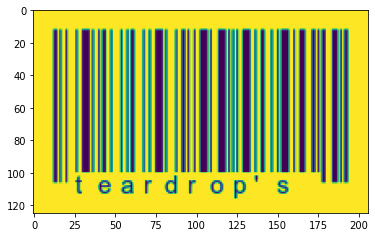

In [14]:
plt.imshow(img2)

In [15]:
def getMSE(img1, img2):  # MSE of 2 images
    return (np.sum(np.square(img1 - img2))) / img1.size

print(getMSE(img,img2))

0.0


In [22]:
#Huffman Coding
#Obtenim  l''string i escomputa la freq de cada caracter a l'string
#es calculen prob
#es compute huffman c (length, variance and entrpy)
probabilities = []

class HuffmanCode:
    def __init__(self,probability):
        self.probability = probability

    def position(self, value, index):
        for j in range(len(self.probability)):
            if(value >= self.probability[j]):
                return j
        return index-1

    def characteristics_huffman_code(self, code):
        length_of_code = [len(k) for k in code]

        mean_length = sum([a*b for a, b in zip(length_of_code, self.probability)])

        print("Average length of the code: %f" % mean_length)
        print("Efficiency of the code: %f" % (entropy_of_code/mean_length))

    def compute_code(self):
        num = len(self.probability)
        huffman_code = ['']*num

        for i in range(num-2):
            val = self.probability[num-i-1] + self.probability[num-i-2]
            if(huffman_code[num-i-1] != '' and huffman_code[num-i-2] != ''):
                huffman_code[-1] = ['1' + symbol for symbol in huffman_code[-1]]
                huffman_code[-2] = ['0' + symbol for symbol in huffman_code[-2]]
            elif(huffman_code[num-i-1] != ''):
                huffman_code[num-i-2] = '0'
                huffman_code[-1] = ['1' + symbol for symbol in huffman_code[-1]]
            elif(huffman_code[num-i-2] != ''):
                huffman_code[num-i-1] = '1'
                huffman_code[-2] = ['0' + symbol for symbol in huffman_code[-2]]
            else:
                huffman_code[num-i-1] = '1'
                huffman_code[num-i-2] = '0'

            position = self.position(val, i)
            probability = self.probability[0:(len(self.probability) - 2)]
            probability.insert(position, val)
            if(isinstance(huffman_code[num-i-2], list) and isinstance(huffman_code[num-i-1], list)):
                complete_code = huffman_code[num-i-1] + huffman_code[num-i-2]
            elif(isinstance(huffman_code[num-i-2], list)):
                complete_code = huffman_code[num-i-2] + [huffman_code[num-i-1]]
            elif(isinstance(huffman_code[num-i-1], list)):
                complete_code = huffman_code[num-i-1] + [huffman_code[num-i-2]]
            else:
                complete_code = [huffman_code[num-i-2], huffman_code[num-i-1]]

            huffman_code = huffman_code[0:(len(huffman_code)-2)]
            huffman_code.insert(position, complete_code)

        huffman_code[0] = ['0' + symbol for symbol in huffman_code[0]]
        huffman_code[1] = ['1' + symbol for symbol in huffman_code[1]]

        if(len(huffman_code[1]) == 0):
            huffman_code[1] = '1'

        count = 0
        final_code = ['']*num

        for i in range(2):
            for j in range(len(huffman_code[i])):
                final_code[count] = huffman_code[i][j]
                count += 1

        final_code = sorted(final_code, key=len)
        return final_code

In [33]:
def rel_freq(x):
    freqs = [(value, x.count(value) / len(x)) for value in set(x)] 
    return freqs

In [ ]:
freq= rel_freq(wordImage)

length = len(wordImage)
probabilities = sorted(probabilities, reverse=True)
huffmanClassObject = (probabilities)
P = probabilities

In [40]:
print(probabilities)

[]


In [ ]:


huffman_code = huffmanClassObject.compute_code()

print(' Value | Huffman code ')
print('----------------------')

for id,char in enumerate(freq):
    if huffman_code[id]=='':
        print(' %-4r |%12s' % (char[0], 1))
        continue
    print(' %-4r |%12s' % (char[0], huffman_code[id]))

huffmanClassObject.characteristics_huffman_code(huffman_code)

In [ ]:
#el codi hufmman que he provat era per paraules i no va be

In [ ]:
#podem deixar aquesta ultima cell sempre per ser un to-do list
#Per ara tenim fins a la linia 100 aprox 
#podriem calcular la segona linia diferent a partir de la primera
#sabent els espais en blanc de la primera fila no faria falta tornar a guardarho
#podem calcular un huffman per codificar la paraula
#sembla que hi ha un error a la cell 12